### Import libraries and dataset connection

In [1]:
import os, sys
from typing import List
from collections.abc import Callable

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8.27
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'

In [6]:
from ipywidgets import interact, interact_manual, FloatSlider

In [7]:
sys.path.append(os.path.abspath('..'))

from src.utils import FILES, DATA_FOLDERS, extract_study_phase, load_dataset, fetch_data, preprocess, create_dataset

CONNECTION_DIR = '/Users/arnauddhaene/Downloads/'

### Blood features correlation analysis

In [67]:
blood = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['blood']))
blood.rename(columns={feature: feature.replace('-', '_') for feature in blood.columns}, inplace=True)
# Listify immunotherapy type to create multi-feature encoding
blood['immuno_therapy_type'] = blood.immuno_therapy_type \
    .apply(lambda t: ['ipi', 'nivo'] if t == 'ipinivo' else [t])

cv = CountVectorizer(analyzer=set)

blood = pd.concat([
    blood.drop(columns=['immuno_therapy_type']), 
    pd.DataFrame(cv.fit_transform(blood['immuno_therapy_type']).todense().astype(bool), columns=cv.get_feature_names())],
    axis=1)

blood = blood.astype({
    f: bool
    for f in ['nivo_maintenance', 'prior_targeted_therapy', 'prior_treatment', 'concomittant_tvec', 'concomittant_LAG3']
})

In [66]:
blood.head()

,gpcr_id,n_days_to_treatment_start,n_days_to_treatment_end,sex,bmi,has_brain_mets,performance_score_ecog,asat_sang_ul,bili_totale_sang_umoll,mono_absolus_gl,...,BRAF_MUTATION,BRAF_MUT_TYPE,concomittant_tvec,concomittant_LAG3,prior_targeted_therapy,prior_treatment,nivo_maintenance,ipi,nivo,pembro
0,34610001,0.0,-63.0,female,28.40,n,1,33.0,NaN,0.37,...,0,NaN,False,False,False,False,True,True,True,False
1,34610096,0.0,-63.0,female,19.61,n,0,23.0,5.0,0.52,...,0,NaN,False,False,False,False,False,True,False,False
2,34610002,0.0,-49.0,male,24.62,y,0,31.0,22.0,0.51,...,0,NaN,False,False,False,False,False,True,True,False
3,34610097,0.0,-78.0,female,20.87,y,2,22.0,6.0,0.72,...,0,NaN,False,False,False,False,False,True,False,False
4,34610003,0.0,0.0,female,25.61,n,0,NaN,NaN,NaN,...,0,NaN,False,False,False,False,False,True,True,False


In [59]:
@interact(feature=blood.columns)
def feature_value_counts(feature: str):
    print(blood[feature].value_counts())

interactive(children=(Dropdown(description='feature', options=('gpcr_id', 'n_days_to_treatment_start', 'n_days…

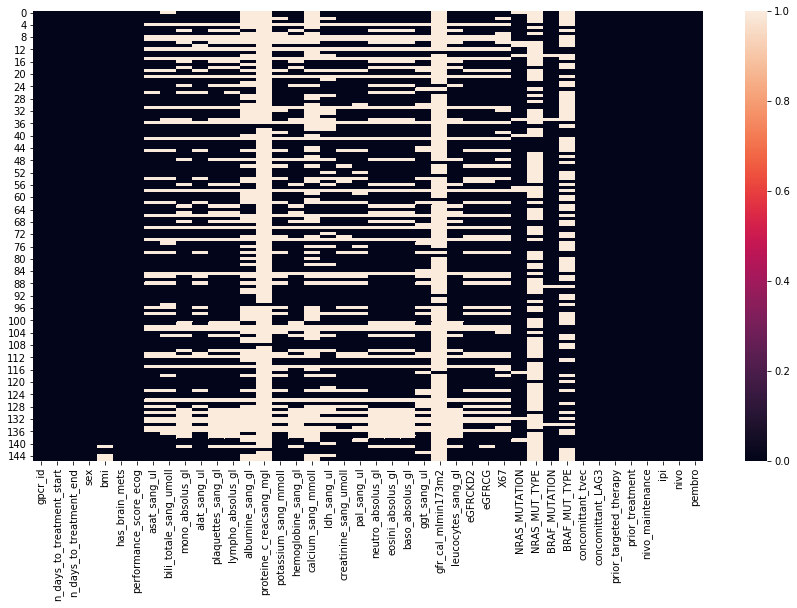

In [46]:
sns.heatmap(blood.isna())

In [47]:
@interact(percent_na=.3)
def show_null_features(percent_na: float):
    na = blood.isnull().mean()
    print(na[na > percent_na])

interactive(children=(FloatSlider(value=0.3, description='percent_na', max=0.8999999999999999, min=-0.3), Outp…

In [48]:
numerical = list(blood.select_dtypes(np.number).columns)
categorical = list(blood.select_dtypes(object).columns)

numerical, categorical

(['gpcr_id',
  'n_days_to_treatment_start',
  'n_days_to_treatment_end',
  'bmi',
  'performance_score_ecog',
  'asat_sang_ul',
  'bili_totale_sang_umoll',
  'mono_absolus_gl',
  'alat_sang_ul',
  'plaquettes_sang_gl',
  'lympho_absolus_gl',
  'albumine_sang_gl',
  'proteine_c_reacsang_mgl',
  'potassium_sang_mmoll',
  'hemoglobine_sang_gl',
  'calcium_sang_mmoll',
  'ldh_sang_ul',
  'creatinine_sang_umoll',
  'pal_sang_ul',
  'neutro_absolus_gl',
  'eosini_absolus_gl',
  'baso_absolus_gl',
  'ggt_sang_ul',
  'gfr_cal_mlmin173m2',
  'leucocytes_sang_gl',
  'eGFRCKD2',
  'eGFRCG',
  'X67',
  'concomittant_tvec',
  'concomittant_LAG3',
  'prior_targeted_therapy',
  'prior_treatment',
  'nivo_maintenance'],
 ['sex',
  'has_brain_mets',
  'NRAS_MUTATION',
  'NRAS_MUT_TYPE',
  'BRAF_MUTATION',
  'BRAF_MUT_TYPE'])